<a href="https://colab.research.google.com/github/Joana-Mansa/brain_segmentation_using_spm/blob/Joana-Mansa-patch-1/brain_segmentation_using_spm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPM for Brain Tissue Segmentation for T1 Images

1. Generate probability maps for the brain tissues using SPM
2. Convert the PMs into binary masks
3. Merge the tissues to form a brain segment
4. Computer the dice score between the segmented image and the test label

In [ ]:
from scipy.optimize import minimize
from scipy.ndimage import map_coordinates
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from inspect import classify_class_attrs

## Patient 1

In [ ]:
from google.colab import files

#Load the four brain images provided with the notebook
uploaded = files.upload()

#### 2. Convert the PMs into Masks

In [ ]:
# Load the probability maps generated by SPM
gray_matter_prob = nib.load('c1T1.nii').get_fdata()
white_matter_prob = nib.load('c2T1.nii').get_fdata()
csf_prob = nib.load('c3T1.nii').get_fdata()
air_prob = nib.load('c6T1.nii').get_fdata()

# Stack all probability maps into one array in the order: gray matter, white matter, CSF
prob_maps = np.stack([csf_prob, gray_matter_prob, white_matter_prob], axis=-1)

# Determine the background using a threshold on all tissue probabilities
background_mask = np.all(prob_maps < 0.1, axis=-1)  # Threshold to determine background

# Create the hard segmentation by finding the index of the maximum probability for each voxel
# This labels: 0 = background, 1 = gray matter, 2 = white matter, 3 = CSF
hard_segmentation = np.argmax(prob_maps, axis=-1) + 1

# Apply the background mask to set background voxels to 0
hard_segmentation[background_mask] = 0

# Convert the segmentation to uint8 type for saving
hard_segmentation = hard_segmentation.astype(np.uint8)

# Save the hard segmentation as a NIfTI file
hard_seg_img = nib.Nifti1Image(hard_segmentation, affine=nib.load('c1T1.nii').affine)
nib.save(hard_seg_img, 'T1_SPM_Seg.nii.gz')

# Create a skull-stripped version by masking the brain tissues (classes 1, 2, and 3)
# Note: 0 is background, so we mask only the brain tissues
skull_stripped_mask = np.isin(hard_segmentation, [1, 2, 3]).astype(np.uint8)

# Save the skull-stripped mask as a NIfTI file
skull_stripped_img = nib.Nifti1Image(skull_stripped_mask, affine=nib.load('c1T1.nii').affine)
nib.save(skull_stripped_img, 'T1_SPM_SS.nii.gz')


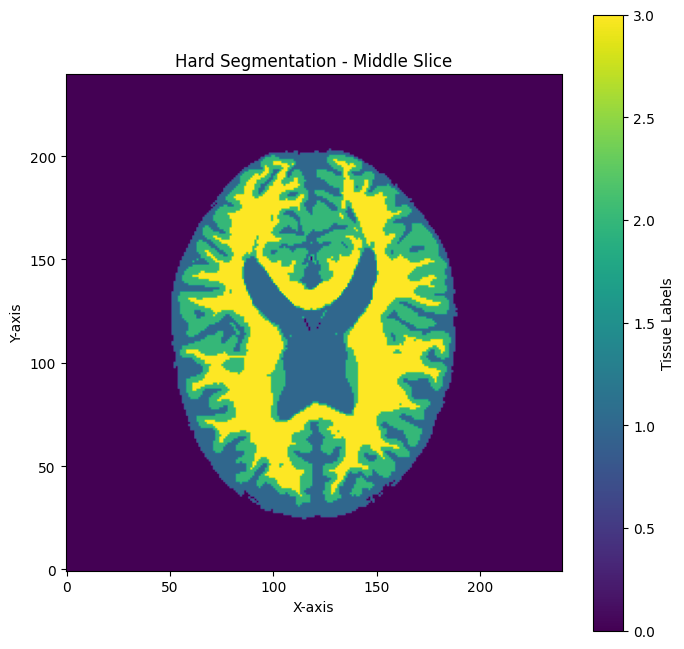

In [ ]:
# Load the hard segmentation NIfTI file
hard_seg_img = nib.load('T1_SPM_Seg.nii.gz')
hard_seg_data = hard_seg_img.get_fdata()

# Select a middle slice along a specific axis (e.g., the axial plane, z-axis)
slice_index = hard_seg_data.shape[2] // 2  # Middle slice
slice_data = hard_seg_data[:, :, slice_index]

# Plot the slice using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(slice_data.T, origin='lower')  # Transpose for correct orientation
plt.colorbar(label='Tissue Labels')
plt.title('Hard Segmentation - Middle Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


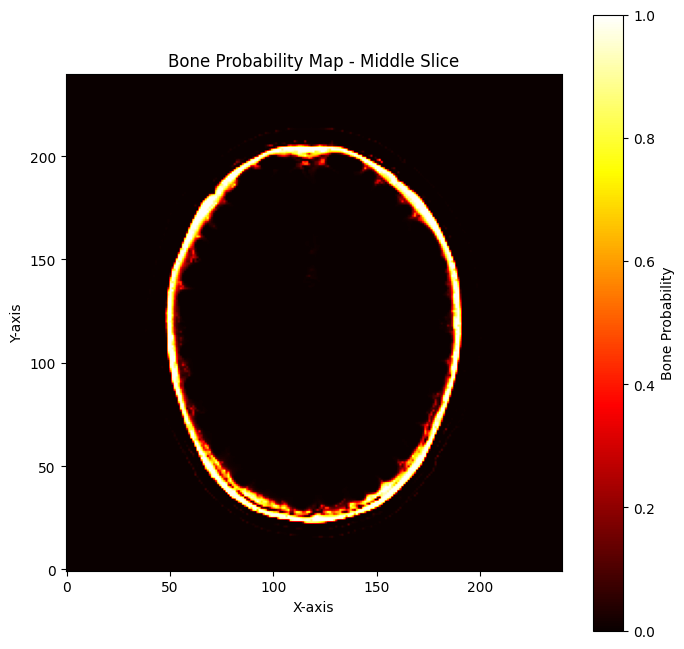

In [ ]:
# Load the bone probability map
bone_prob = nib.load('c4T1.nii').get_fdata()

# Select a middle slice along the z-axis for visualization
slice_index = bone_prob.shape[2] // 2  # Middle slice
bone_slice = bone_prob[:, :, slice_index]

# Plot the bone mask slice using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(bone_slice.T, cmap='hot', origin='lower')  # Use 'hot' colormap for better contrast
plt.colorbar(label='Bone Probability')
plt.title('Bone Probability Map - Middle Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


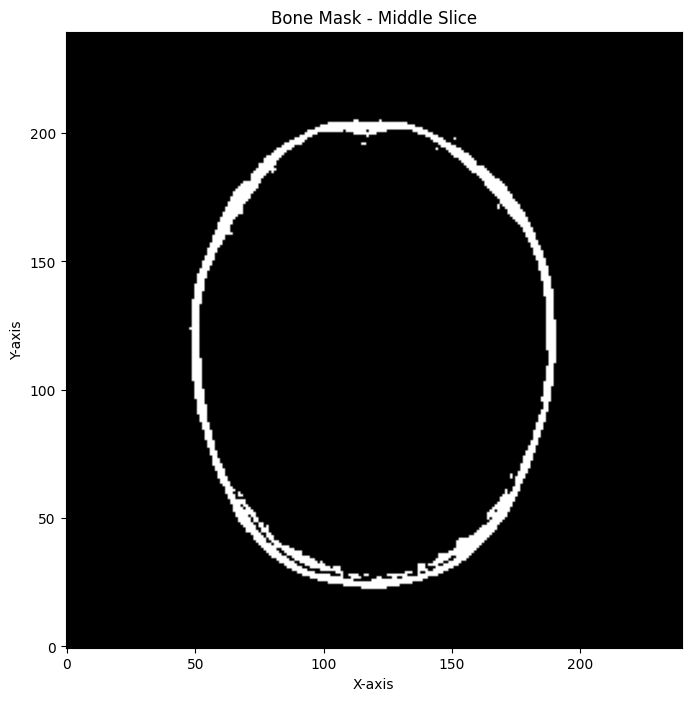

In [ ]:
# Load the bone probability map
bone_prob = nib.load('c4T1.nii').get_fdata()

# Define a threshold for the bone mask (e.g., 0.5)
bone_threshold = 0.5
bone_mask = (bone_prob >= bone_threshold).astype(np.uint8)

# Select a middle slice along the z-axis for visualization
slice_index = bone_mask.shape[2] // 2  # Middle slice
bone_slice = bone_mask[:, :, slice_index]

# Plot the binary bone mask slice
plt.figure(figsize=(8, 8))
plt.imshow(bone_slice.T, cmap='gray', origin='lower')  # Display in grayscale
plt.title('Bone Mask - Middle Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


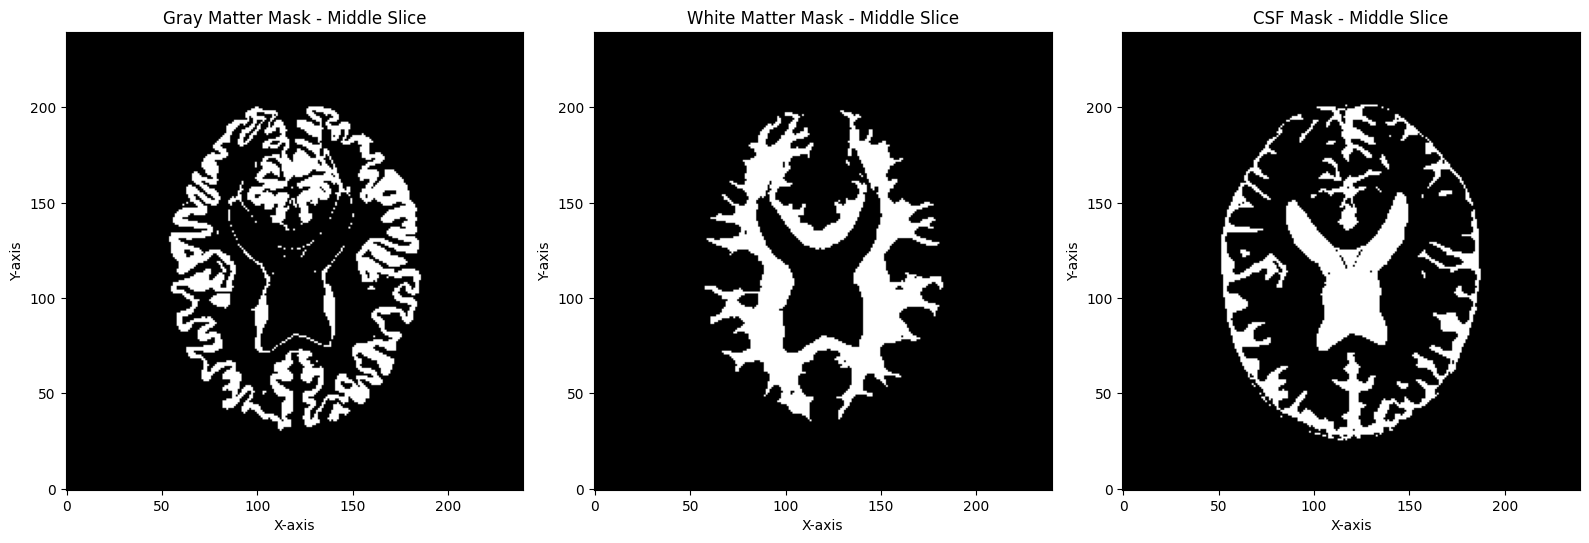

In [ ]:
# Load the probability maps for bone, tissue1, and tissue2
gray_matter_prob = nib.load('c1T1.nii').get_fdata()
white_matter_prob = nib.load('c2T1.nii').get_fdata()
csf_prob = nib.load('c3T1.nii').get_fdata()

# Define thresholds for bone, tissue1, and tissue2 (adjust as needed)
gray_matter_threshold = 0.5
white_matter_threshold = 0.5
csf_threshold = 0.5

# Create binary masks for each tissue based on the threshold
gray_matter_mask = (gray_matter_prob >= gray_matter_threshold).astype(np.uint8)
white_matter_mask = (white_matter_prob >= white_matter_threshold).astype(np.uint8)
csf_mask = (csf_prob >= csf_threshold).astype(np.uint8)

# Select a middle slice along the z-axis for visualization
slice_index = bone_mask.shape[2] // 2  # Middle slice for each tissue

# Extract the corresponding slices for each tissue
gray_matter_slice = gray_matter_mask[:, :, slice_index]
white_matter_slice = white_matter_mask[:, :, slice_index]
csf_slice = csf_mask[:, :, slice_index]

# Plot the binary masks for bone, tissue1, and tissue2
plt.figure(figsize=(16, 8))

# Bone slice
plt.subplot(1, 3, 1)
plt.imshow(gray_matter_slice .T, cmap='gray', origin='lower')
plt.title('Gray Matter Mask - Middle Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Tissue 1 slice
plt.subplot(1, 3, 2)
plt.imshow(white_matter_slice.T, cmap='gray', origin='lower')
plt.title('White Matter Mask - Middle Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Tissue 2 slice
plt.subplot(1, 3, 3)
plt.imshow(csf_slice.T, cmap='gray', origin='lower')
plt.title('CSF Mask - Middle Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plots
plt.tight_layout()
plt.show()


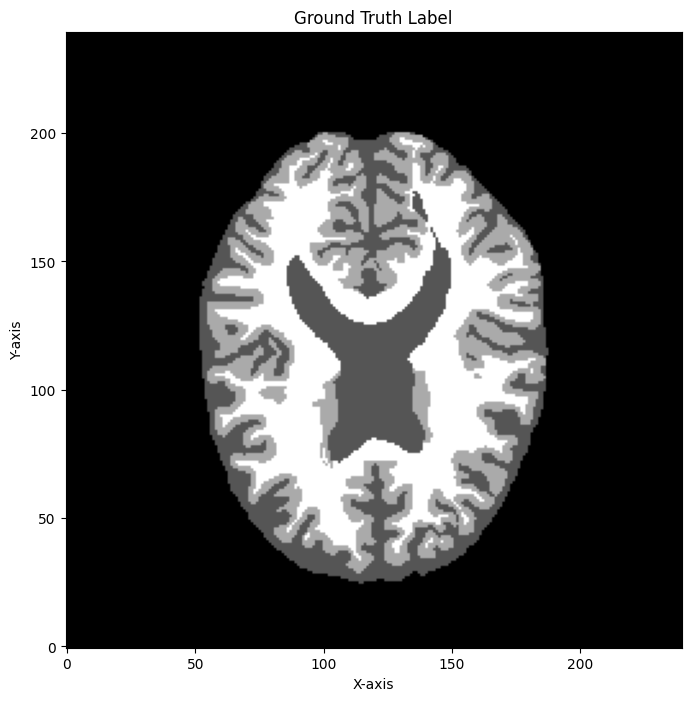

In [ ]:
# Load the skull-stripped NIfTI file
skull_stripped_img = nib.load('LabelsForTesting.nii')
skull_stripped_data = skull_stripped_img.get_fdata()

# Select a middle slice along the z-axis (axial plane)
slice_index = skull_stripped_data.shape[2] // 2  # Middle slice
slice_data = skull_stripped_data[:, :, slice_index]

# Plot the skull-stripped mask using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(slice_data.T, cmap='gray', origin='lower')  # Display in grayscale
plt.title('Ground Truth Label')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


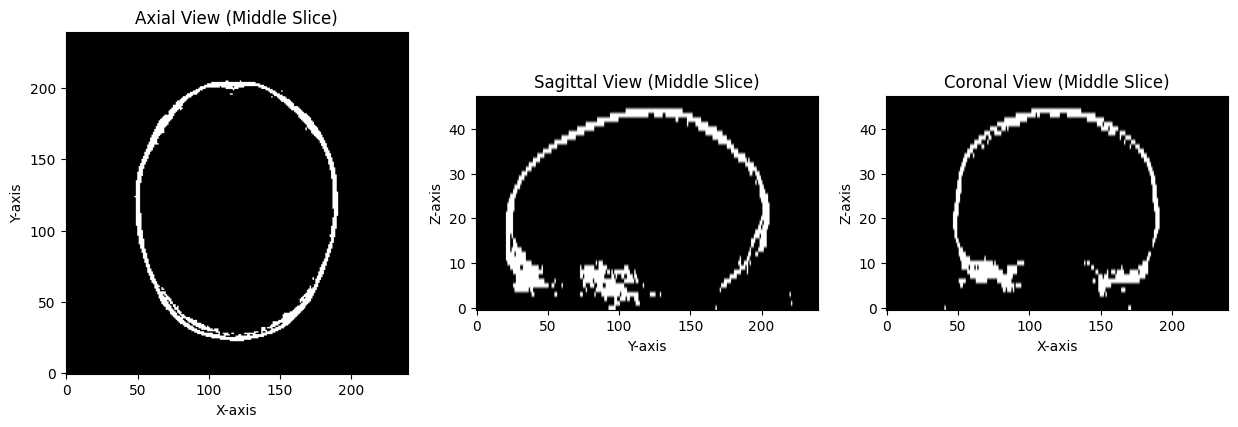

In [ ]:
# Load the bone probability map and its affine matrix
bone_prob = nib.load('c4T1.nii')
bone_data = bone_prob.get_fdata()
affine = bone_prob.affine

# Extract voxel dimensions from the affine matrix
voxel_sizes = np.sqrt(np.sum(affine[:3, :3] ** 2, axis=0))

# Define a threshold for the bone mask (e.g., 0.5)
bone_threshold = 0.5
bone_mask = (bone_data >= bone_threshold).astype(np.uint8)

# Determine the middle slice for each orientation
axial_slice_index = bone_mask.shape[2] // 2  # Middle slice for axial view (z-axis)
sagittal_slice_index = bone_mask.shape[0] // 2  # Middle slice for sagittal view (x-axis)
coronal_slice_index = bone_mask.shape[1] // 2  # Middle slice for coronal view (y-axis)

# Extract slices for each orientation
axial_slice = bone_mask[:, :, axial_slice_index]  # Axial slice
sagittal_slice = bone_mask[sagittal_slice_index, :, :]  # Sagittal slice
coronal_slice = bone_mask[:, coronal_slice_index, :]  # Coronal slice

# Plot each orientation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axes[0].imshow(axial_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[1] / voxel_sizes[0])
axes[0].set_title('Axial View (Middle Slice)')
axes[0].set_xlabel('X-axis')
axes[0].set_ylabel('Y-axis')

# Sagittal view
axes[1].imshow(sagittal_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[2] / voxel_sizes[1])
axes[1].set_title('Sagittal View (Middle Slice)')
axes[1].set_xlabel('Y-axis')
axes[1].set_ylabel('Z-axis')

# Coronal view
axes[2].imshow(coronal_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[2] / voxel_sizes[0])
axes[2].set_title('Coronal View (Middle Slice)')
axes[2].set_xlabel('X-axis')
axes[2].set_ylabel('Z-axis')

# Display the plots
plt.show()


In [ ]:
# Function to calculate Dice coefficient
def dice_coefficient(pred, truth):
    intersection = np.sum((pred > 0) & (truth > 0))
    volume_sum = np.sum(pred > 0) + np.sum(truth > 0)
    if volume_sum == 0:
        return 1.0  # Return perfect match if both volumes are empty
    return 2 * intersection / volume_sum

# Load the ground truth and predicted segmentation images
ground_truth_img = nib.load('LabelsForTesting.nii')
predicted_img = nib.load('T1_SPM_Seg.nii.gz')

# Get the data arrays and convert to integer type
ground_truth_data = ground_truth_img.get_fdata().astype(np.int32)
predicted_data = predicted_img.get_fdata().astype(np.int32)

# Tissue labels in both images: 1 = Gray matter, 2 = White matter, 3 = CSF
tissue_labels = [2, 3, 1]
tissue_names = ['Gray Matter', 'White Matter', 'CSF']

# Calculate the Dice coefficient for each tissue type
dice_scores = {}
for tissue_label, tissue_name in zip(tissue_labels, tissue_names):
    ground_truth_mask = (ground_truth_data == tissue_label).astype(np.uint8)
    predicted_mask = (predicted_data == tissue_label).astype(np.uint8)
    dice_scores[tissue_name] = dice_coefficient(predicted_mask, ground_truth_mask)

# Print the Dice scores for each tissue type
for tissue_name, dice_score in dice_scores.items():
    print(f'Dice coefficient for {tissue_name}: {dice_score:.4f}')


Dice coefficient for Gray Matter: 0.7539
Dice coefficient for White Matter: 0.8281
Dice coefficient for CSF: 0.7796


In [ ]:
print("Ground Truth Image Affine:\n", ground_truth_img.affine)
print("Predicted Image Affine:\n", predicted_img.affine)
print("Ground Truth Image Shape:", ground_truth_data.shape)
print("Predicted Image Shape:", predicted_data.shape)


Ground Truth Image Affine:
 [[ -0.95833302   0.           0.         110.89199829]
 [  0.          -0.91877592  -0.85302001 115.17299652]
 [  0.          -0.27249241   2.87616897 -15.59920025]
 [  0.           0.           0.           1.        ]]
Predicted Image Affine:
 [[ -0.95833302   0.           0.         110.89199829]
 [  0.          -0.91877592  -0.85301995 115.17299652]
 [  0.          -0.27249241   2.87616897 -15.5992012 ]
 [  0.           0.           0.           1.        ]]
Ground Truth Image Shape: (240, 240, 48)
Predicted Image Shape: (240, 240, 48)


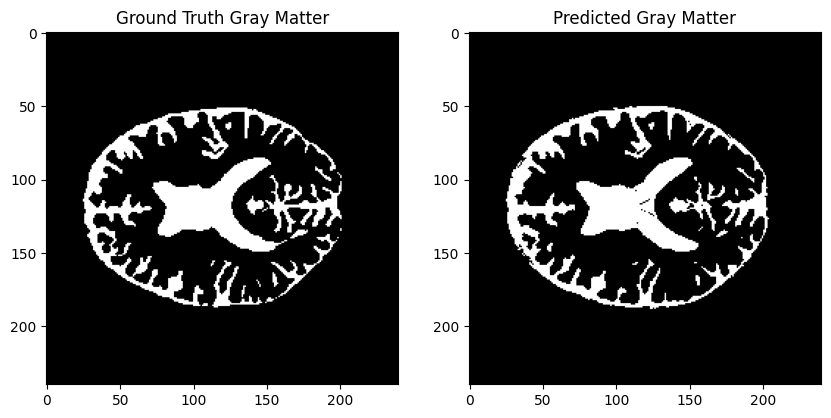

In [ ]:
# Extract gray matter masks
ground_truth_gray = (ground_truth_data == 1).astype(np.uint8)
predicted_gray = (predicted_data == 1).astype(np.uint8)

# Plot overlay of ground truth and predicted gray matter masks
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ground_truth_gray[:, :, ground_truth_gray.shape[2] // 2], cmap='gray')
plt.title('Ground Truth Gray Matter')
plt.subplot(1, 2, 2)
plt.imshow(predicted_gray[:, :, predicted_gray.shape[2] // 2], cmap='gray')
plt.title('Predicted Gray Matter')
plt.show()


In [ ]:
print(ground_truth_img.affine)
print(predicted_img.affine)


[[ -0.95833302   0.           0.         110.89199829]
 [  0.          -0.91877592  -0.85302001 115.17299652]
 [  0.          -0.27249241   2.87616897 -15.59920025]
 [  0.           0.           0.           1.        ]]
[[ -0.95833302   0.           0.         110.89199829]
 [  0.          -0.91877592  -0.85301995 115.17299652]
 [  0.          -0.27249241   2.87616897 -15.5992012 ]
 [  0.           0.           0.           1.        ]]


In [ ]:
print(np.unique(ground_truth_data))
print(np.unique(predicted_data))


[0 1 2 3]
[0 1 2 3]


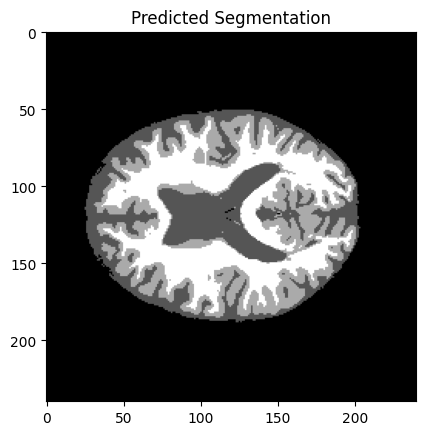

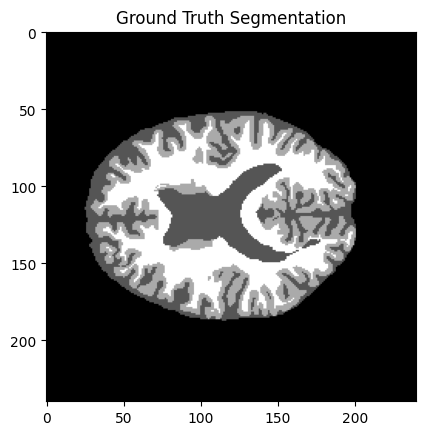

In [ ]:

# Show a middle slice of the predicted segmentation
plt.imshow(predicted_data[:, :, predicted_data.shape[2] // 2], cmap='gray')
plt.title('Predicted Segmentation')
plt.show()

# Show the corresponding slice of the ground truth segmentation
plt.imshow(ground_truth_data[:, :, ground_truth_data.shape[2] // 2], cmap='gray')
plt.title('Ground Truth Segmentation')
plt.show()


#### Finding the Mean and Standard deviation of the Tissues

In [ ]:
# Load the ground truth and predicted NIfTI images
ground_truth_path = 'LabelsForTesting.nii'
predicted_path = 'T1_SPM_Seg.nii.gz'

ground_truth_img = nib.load(ground_truth_path)
predicted_img = nib.load(predicted_path)

# Get the data arrays from the NIfTI images
ground_truth_data = ground_truth_img.get_fdata()
predicted_data = predicted_img.get_fdata()

# Define unique tissue labels in the ground truth (e.g., 0 for background, 1 for gray matter, etc.)
tissue_labels = np.unique(ground_truth_data)

# Initialize dictionaries to store mean and std for each tissue
mean_values = {}
std_values = {}

# Loop over each tissue label
for label in tissue_labels:
    # Extract regions of the current tissue in the predicted image
    tissue_region_pred = predicted_data[ground_truth_data == label]

    # Check if there are any voxels for this label
    if tissue_region_pred.size > 0:
        # Calculate mean and standard deviation
        mean_values[label] = np.mean(tissue_region_pred)
        std_values[label] = np.std(tissue_region_pred)
    else:
        mean_values[label] = None
        std_values[label] = None

# Output the results
for label in tissue_labels:
    print(f'Tissue Label {label}: Mean = {mean_values[label]}, Standard Deviation = {std_values[label]}')


Tissue Label 0.0: Mean = 0.06617819074734822, Standard Deviation = 0.3520001106718106
Tissue Label 1.0: Mean = 1.0874782873685815, Standard Deviation = 0.34555071584380503
Tissue Label 2.0: Mean = 2.022969744985793, Standard Deviation = 0.403142929571644
Tissue Label 3.0: Mean = 2.867727798112117, Standard Deviation = 0.35015759064531815


## Patient 2

In [ ]:
# Load the probability maps generated by SPM
gray_matter_prob_2 = nib.load('c1T1_2.nii').get_fdata()
white_matter_prob_2 = nib.load('c2T1_2.nii').get_fdata()
csf_prob_2 = nib.load('c3T1_2.nii').get_fdata()
bone_prob_2 = nib.load('c4T1_2.nii').get_fdata()
# soft_tissue_prob_2 = nib.load('c5T1_2.nii').get_fdata()
air_prob_2 = nib.load('c6T1_2.nii').get_fdata()

# Stack all probability maps into one array
prob_maps_2 = np.stack([csf_prob_2, gray_matter_prob_2, white_matter_prob_2], axis=-1)
background_mask_2 = np.all(prob_maps_2 < 0.1, axis=-1)  # Threshold to determine background

# Create the hard segmentation by finding the index of the maximum probability for each voxel
hard_segmentation_2 = np.argmax(prob_maps_2, axis=-1) + 1  # Adding 1 to label the classes from 1 to 6

# Apply the background mask to set background voxels to 0
hard_segmentation_2[background_mask_2] = 0

hard_segmentation_2 = hard_segmentation_2.astype(np.uint8)

# Save the hard segmentation as a NIfTI file
# affine contains information about the image's orientation and voxel size
# this code sets the affine transformation from one of the loaded prob maps
# ensuring that the saved segmentation has correct spatial properties
hard_seg_img = nib.Nifti1Image(hard_segmentation_2, affine=nib.load('c1T1_2.nii').affine)
nib.save(hard_seg_img, 'T1_SPM_Seg_2.nii.gz')

# Create a skull-stripped version by masking the brain tissues (classes 1, 2, and 3)
skull_stripped_mask = np.isin(hard_segmentation, [1, 2, 3]).astype(np.uint8)

# Save the skull-stripped mask as a NIfTI file
skull_stripped_img = nib.Nifti1Image(skull_stripped_mask, affine=nib.load('c1T1_2.nii').affine)
nib.save(skull_stripped_img, 'T1_SPM_SS_2.nii.gz')


In [ ]:
# Load the ground truth and predicted segmentation images
ground_truth_img = nib.load('LabelsForTesting_2.nii')
predicted_img = nib.load('T1_SPM_Seg_2.nii.gz')

# Get the data arrays
ground_truth_data = ground_truth_img.get_fdata()
predicted_data = predicted_img.get_fdata()

# Tissue labels in both images: 1 = Gray matter, 2 = White matter, 3 = CSF
tissue_labels = [2, 3, 1]
tissue_names = ['Gray Matter', 'White Matter', 'CSF']

# Calculate the Dice coefficient for each tissue type
dice_scores = {}
for tissue_label, tissue_name in zip(tissue_labels, tissue_names):
    ground_truth_mask = (ground_truth_data == tissue_label).astype(np.uint8)
    predicted_mask = (predicted_data == tissue_label).astype(np.uint8)
    dice_scores[tissue_name] = dice_coefficient(predicted_mask, ground_truth_mask)

# Print the Dice scores for each tissue type
for tissue_name, dice_score in dice_scores.items():
    print(f'Dice coefficient for {tissue_name}: {dice_score:.4f}')


Dice coefficient for Gray Matter: 0.7062
Dice coefficient for White Matter: 0.7605
Dice coefficient for CSF: 0.7205


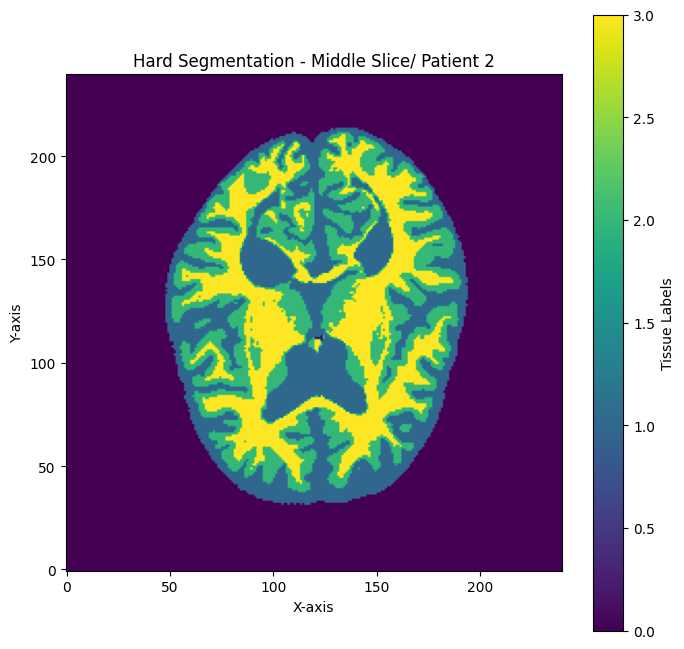

In [ ]:
# Load the hard segmentation NIfTI file
hard_seg_img = nib.load('T1_SPM_Seg_2.nii.gz')
hard_seg_data = hard_seg_img.get_fdata()

# Select a middle slice along a specific axis (e.g., the axial plane, z-axis)
slice_index = hard_seg_data.shape[2] // 2  # Middle slice
slice_data = hard_seg_data[:, :, slice_index]

# Plot the slice using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(slice_data.T, origin='lower')  # Transpose for correct orientation
plt.colorbar(label='Tissue Labels')
plt.title('Hard Segmentation - Middle Slice/ Patient 2')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


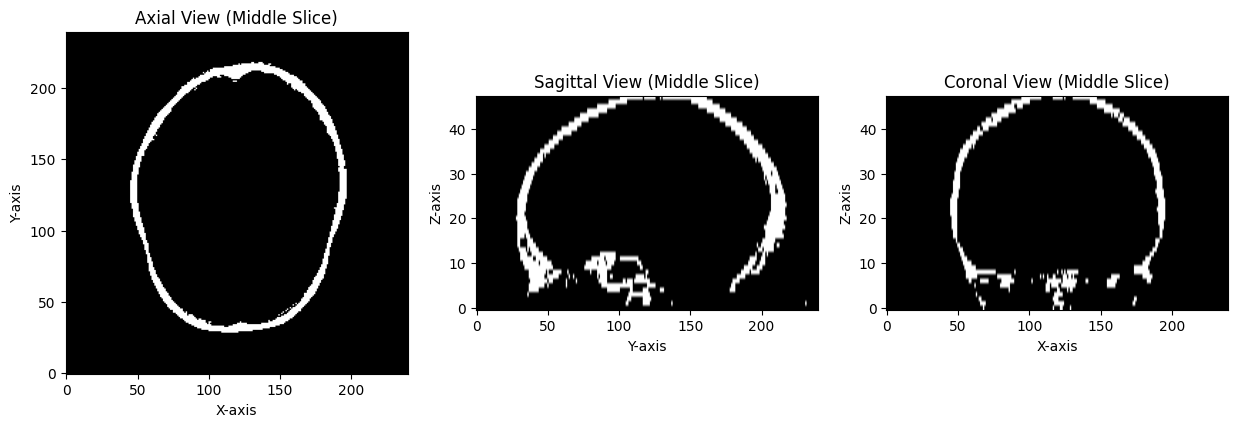

In [ ]:
# Load the bone probability map and its affine matrix
bone_prob = nib.load('c4T1_2.nii')
bone_data = bone_prob.get_fdata()
affine = bone_prob.affine

# Extract voxel dimensions from the affine matrix
voxel_sizes = np.sqrt(np.sum(affine[:3, :3] ** 2, axis=0))

# Define a threshold for the bone mask (e.g., 0.5)
bone_threshold = 0.5
bone_mask = (bone_data >= bone_threshold).astype(np.uint8)

# Determine the middle slice for each orientation
axial_slice_index = bone_mask.shape[2] // 2  # Middle slice for axial view (z-axis)
sagittal_slice_index = bone_mask.shape[0] // 2  # Middle slice for sagittal view (x-axis)
coronal_slice_index = bone_mask.shape[1] // 2  # Middle slice for coronal view (y-axis)

# Extract slices for each orientation
axial_slice = bone_mask[:, :, axial_slice_index]  # Axial slice
sagittal_slice = bone_mask[sagittal_slice_index, :, :]  # Sagittal slice
coronal_slice = bone_mask[:, coronal_slice_index, :]  # Coronal slice

# Plot each orientation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axes[0].imshow(axial_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[1] / voxel_sizes[0])
axes[0].set_title('Axial View (Middle Slice)')
axes[0].set_xlabel('X-axis')
axes[0].set_ylabel('Y-axis')

# Sagittal view
axes[1].imshow(sagittal_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[2] / voxel_sizes[1])
axes[1].set_title('Sagittal View (Middle Slice)')
axes[1].set_xlabel('Y-axis')
axes[1].set_ylabel('Z-axis')

# Coronal view
axes[2].imshow(coronal_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[2] / voxel_sizes[0])
axes[2].set_title('Coronal View (Middle Slice)')
axes[2].set_xlabel('X-axis')
axes[2].set_ylabel('Z-axis')

# Display the plots
plt.show()


In [ ]:
# Load the ground truth and predicted NIfTI images
ground_truth_path = 'LabelsForTesting_2.nii'
predicted_path = 'T1_SPM_Seg_2.nii.gz'

ground_truth_img = nib.load(ground_truth_path)
predicted_img = nib.load(predicted_path)

# Get the data arrays from the NIfTI images
ground_truth_data = ground_truth_img.get_fdata()
predicted_data = predicted_img.get_fdata()

# Define unique tissue labels in the ground truth (e.g., 0 for background, 1 for gray matter, etc.)
tissue_labels = np.unique(ground_truth_data)

# Initialize dictionaries to store mean and std for each tissue
mean_values = {}
std_values = {}

# Loop over each tissue label
for label in tissue_labels:
    # Extract regions of the current tissue in the predicted image
    tissue_region_pred = predicted_data[ground_truth_data == label]

    # Check if there are any voxels for this label
    if tissue_region_pred.size > 0:
        # Calculate mean and standard deviation
        mean_values[label] = np.mean(tissue_region_pred)
        std_values[label] = np.std(tissue_region_pred)
    else:
        mean_values[label] = None
        std_values[label] = None

# Output the results
for label in tissue_labels:
    print(f'Tissue Label {label}: Mean = {mean_values[label]}, Standard Deviation = {std_values[label]}')


Tissue Label 0.0: Mean = 0.07822077145512617, Standard Deviation = 0.37993204971701783
Tissue Label 1.0: Mean = 1.0226671089517194, Standard Deviation = 0.2078169095510029
Tissue Label 2.0: Mean = 1.9258013055596304, Standard Deviation = 0.5517909779887822
Tissue Label 3.0: Mean = 2.7784374567965715, Standard Deviation = 0.4895848009150035


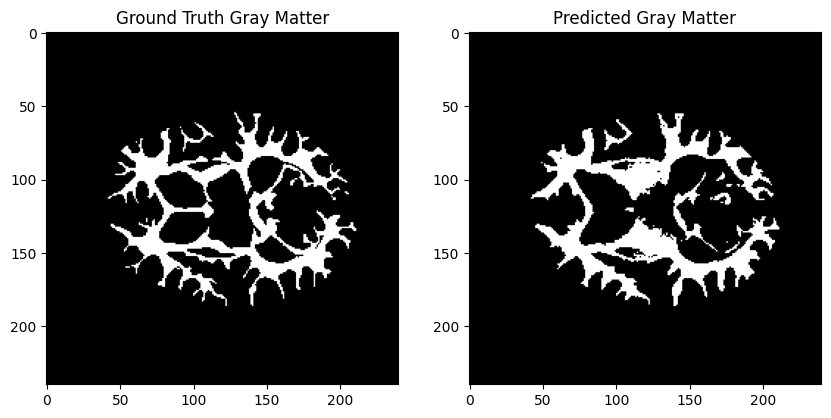

In [ ]:
import matplotlib.pyplot as plt

# Extract gray matter masks
ground_truth_gray = (ground_truth_data == 3).astype(np.uint8)
predicted_gray = (predicted_data == 3).astype(np.uint8)

# Plot overlay of ground truth and predicted gray matter masks
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ground_truth_gray[:, :, ground_truth_gray.shape[2] // 2], cmap='gray')
plt.title('Ground Truth Gray Matter')
plt.subplot(1, 2, 2)
plt.imshow(predicted_gray[:, :, predicted_gray.shape[2] // 2], cmap='gray')
plt.title('Predicted Gray Matter')
plt.show()


In [ ]:
print(np.unique(ground_truth_data))
print(np.unique(predicted_data))


[0. 1. 2. 3.]
[0. 1. 2. 3.]


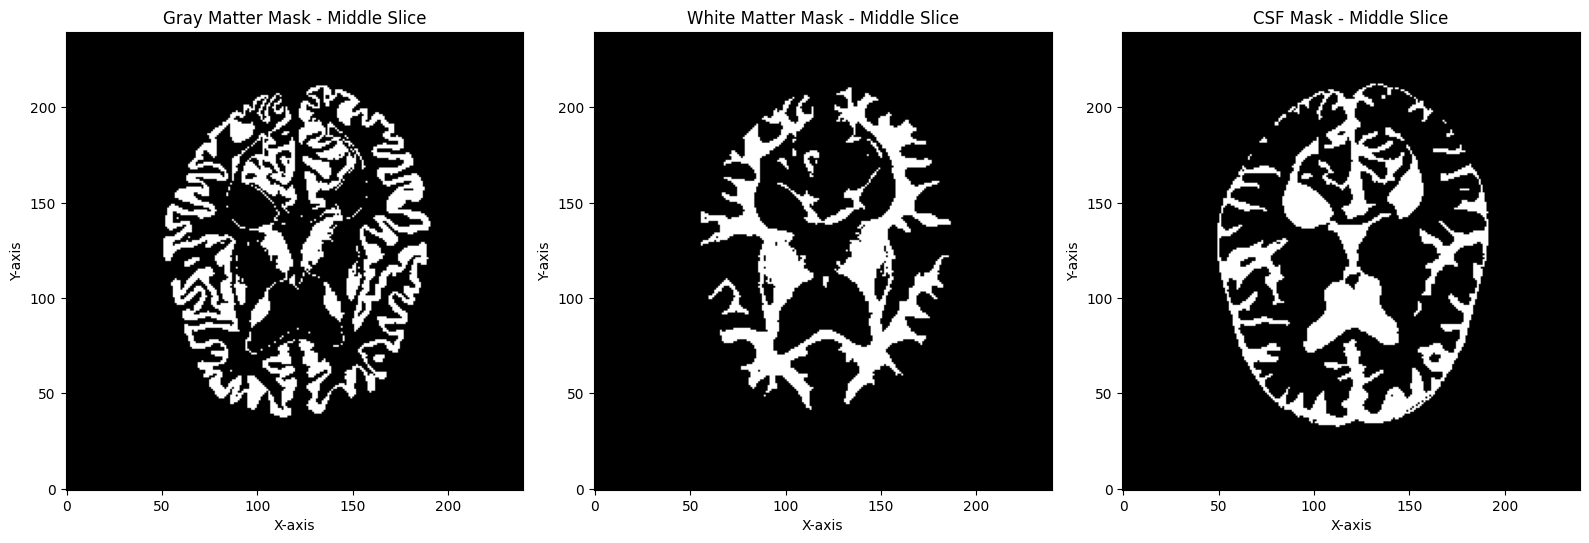

In [ ]:

# Load the probability maps for bone, tissue1, and tissue2
gray_matter_prob = nib.load('c1T1_2.nii').get_fdata()
white_matter_prob = nib.load('c2T1_2.nii').get_fdata()
csf_prob = nib.load('c3T1_2.nii').get_fdata()

# Define thresholds for bone, tissue1, and tissue2 (adjust as needed)
gray_matter_threshold = 0.5
white_matter_threshold = 0.5
csf_threshold = 0.5

# Create binary masks for each tissue based on the threshold
gray_matter_mask = (gray_matter_prob >= gray_matter_threshold).astype(np.uint8)
white_matter_mask = (white_matter_prob >= white_matter_threshold).astype(np.uint8)
csf_mask = (csf_prob >= csf_threshold).astype(np.uint8)

# Select a middle slice along the z-axis for visualization
slice_index = bone_mask.shape[2] // 2  # Middle slice for each tissue

# Extract the corresponding slices for each tissue
gray_matter_slice = gray_matter_mask[:, :, slice_index]
white_matter_slice = white_matter_mask[:, :, slice_index]
csf_slice = csf_mask[:, :, slice_index]

# Plot the binary masks for bone, tissue1, and tissue2
plt.figure(figsize=(16, 8))

# Bone slice
plt.subplot(1, 3, 1)
plt.imshow(gray_matter_slice .T, cmap='gray', origin='lower')
plt.title('Gray Matter Mask - Middle Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Tissue 1 slice
plt.subplot(1, 3, 2)
plt.imshow(white_matter_slice.T, cmap='gray', origin='lower')
plt.title('White Matter Mask - Middle Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Tissue 2 slice
plt.subplot(1, 3, 3)
plt.imshow(csf_slice.T, cmap='gray', origin='lower')
plt.title('CSF Mask - Middle Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plots
plt.tight_layout()
plt.show()


## Patient 3

In [ ]:
# Load the probability maps generated by SPM
gray_matter_prob_3 = nib.load('c1T1_3.nii').get_fdata()
white_matter_prob_3 = nib.load('c2T1_3.nii').get_fdata()
csf_prob_3 = nib.load('c3T1_3.nii').get_fdata()
bone_prob_3 = nib.load('c4T1_3.nii').get_fdata()
# soft_tissue_prob_2 = nib.load('c5T1_2.nii').get_fdata()
air_prob_3 = nib.load('c6T1_3.nii').get_fdata()

# Stack all probability maps into one array
prob_maps_3 = np.stack([csf_prob_3,gray_matter_prob_3, white_matter_prob_3], axis=-1)
background_mask_3 = np.all(prob_maps_3 < 0.1, axis=-1)  # Threshold to determine background


# Create the hard segmentation by finding the index of the maximum probability for each voxel
hard_segmentation_3 = np.argmax(prob_maps_3, axis=-1) + 1  # Adding 1 to label the classes from 1 to 6

hard_segmentation_3[background_mask_3] = 0

hard_segmentation_3 = hard_segmentation_3.astype(np.uint8)

# Save the hard segmentation as a NIfTI file
# affine contains information about the image's orientation and voxel size
# this code sets the affine transformation from one of the loaded prob maps
# ensuring that the saved segmentation has correct spatial properties
hard_seg_img = nib.Nifti1Image(hard_segmentation_3, affine=nib.load('c1T1_3.nii').affine)
nib.save(hard_seg_img, 'T1_SPM_Seg_3.nii.gz')

# Create a skull-stripped version by masking the brain tissues (classes 1, 2, and 3)
skull_stripped_mask = np.isin(hard_segmentation, [1, 2, 3]).astype(np.uint8)

# Save the skull-stripped mask as a NIfTI file
skull_stripped_img = nib.Nifti1Image(skull_stripped_mask, affine=nib.load('c1T1_3.nii').affine)
nib.save(skull_stripped_img, 'T1_SPM_SS_3.nii.gz')



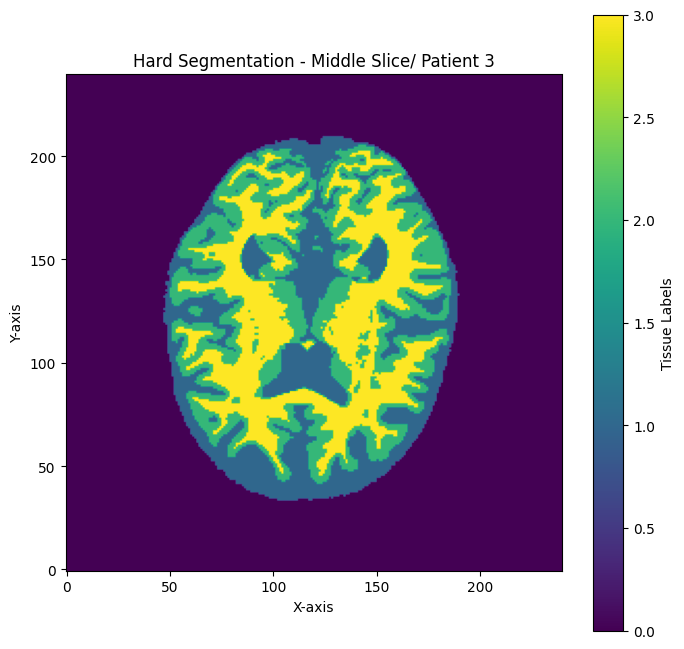

In [ ]:
# Load the hard segmentation NIfTI file
hard_seg_img = nib.load('T1_SPM_Seg_3.nii.gz')
hard_seg_data = hard_seg_img.get_fdata()

# Select a middle slice along a specific axis (e.g., the axial plane, z-axis)
slice_index = hard_seg_data.shape[2] // 2  # Middle slice
slice_data = hard_seg_data[:, :, slice_index]

# Plot the slice using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(slice_data.T, origin='lower')  # Transpose for correct orientation
plt.colorbar(label='Tissue Labels')
plt.title('Hard Segmentation - Middle Slice/ Patient 3')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


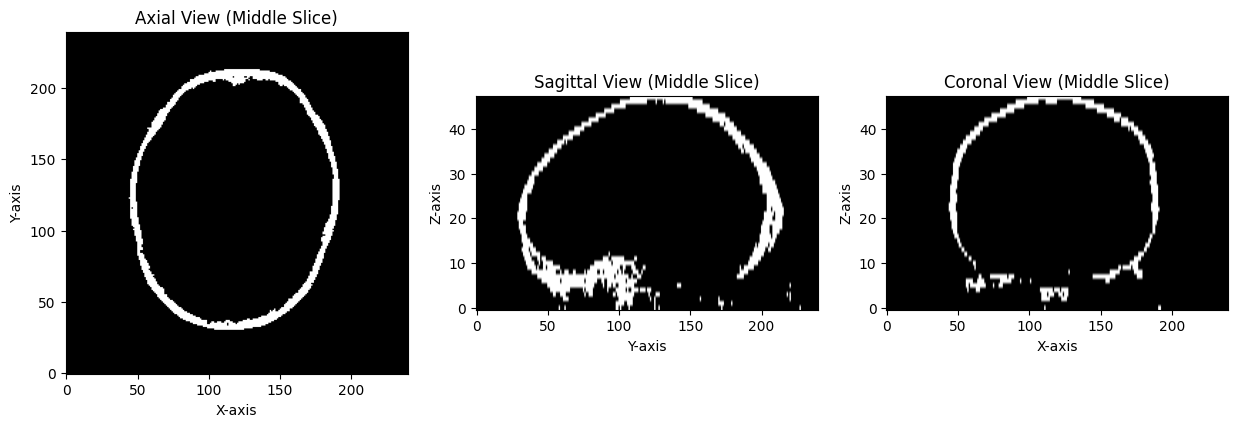

In [ ]:
# Load the bone probability map and its affine matrix
bone_prob = nib.load('c4T1_3.nii')
bone_data = bone_prob.get_fdata()
affine = bone_prob.affine

# Extract voxel dimensions from the affine matrix
voxel_sizes = np.sqrt(np.sum(affine[:3, :3] ** 2, axis=0))

# Define a threshold for the bone mask (e.g., 0.5)
bone_threshold = 0.5
bone_mask = (bone_data >= bone_threshold).astype(np.uint8)

# Determine the middle slice for each orientation
axial_slice_index = bone_mask.shape[2] // 2  # Middle slice for axial view (z-axis)
sagittal_slice_index = bone_mask.shape[0] // 2  # Middle slice for sagittal view (x-axis)
coronal_slice_index = bone_mask.shape[1] // 2  # Middle slice for coronal view (y-axis)

# Extract slices for each orientation
axial_slice = bone_mask[:, :, axial_slice_index]  # Axial slice
sagittal_slice = bone_mask[sagittal_slice_index, :, :]  # Sagittal slice
coronal_slice = bone_mask[:, coronal_slice_index, :]  # Coronal slice

# Plot each orientation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axes[0].imshow(axial_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[1] / voxel_sizes[0])
axes[0].set_title('Axial View (Middle Slice)')
axes[0].set_xlabel('X-axis')
axes[0].set_ylabel('Y-axis')

# Sagittal view
axes[1].imshow(sagittal_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[2] / voxel_sizes[1])
axes[1].set_title('Sagittal View (Middle Slice)')
axes[1].set_xlabel('Y-axis')
axes[1].set_ylabel('Z-axis')

# Coronal view
axes[2].imshow(coronal_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[2] / voxel_sizes[0])
axes[2].set_title('Coronal View (Middle Slice)')
axes[2].set_xlabel('X-axis')
axes[2].set_ylabel('Z-axis')

# Display the plots
plt.show()


In [ ]:
# Load the ground truth and predicted segmentation images
ground_truth_img = nib.load('LabelsForTesting_3.nii')
predicted_img = nib.load('T1_SPM_Seg_3.nii.gz')

# Get the data arrays
ground_truth_data = ground_truth_img.get_fdata()
predicted_data = predicted_img.get_fdata()

# Tissue labels in both images: 1 = Gray matter, 2 = White matter, 3 = CSF
tissue_labels = [ 1, 2, 3]
tissue_names = ['CSF','Gray Matter', 'White Matter']

# Calculate the Dice coefficient for each tissue type
dice_scores = {}
for tissue_label, tissue_name in zip(tissue_labels, tissue_names):
    ground_truth_mask = (ground_truth_data == tissue_label).astype(np.uint8)
    predicted_mask = (predicted_data == tissue_label).astype(np.uint8)
    dice_scores[tissue_name] = dice_coefficient(predicted_mask, ground_truth_mask)

# Print the Dice scores for each tissue type
for tissue_name, dice_score in dice_scores.items():
    print(f'Dice coefficient for {tissue_name}: {dice_score:.4f}')


Dice coefficient for CSF: 0.7238
Dice coefficient for Gray Matter: 0.7327
Dice coefficient for White Matter: 0.8259


In [ ]:
# Load the ground truth and predicted NIfTI images
ground_truth_path = 'LabelsForTesting_3.nii'
predicted_path = 'T1_SPM_Seg_3.nii.gz'

ground_truth_img = nib.load(ground_truth_path)
predicted_img = nib.load(predicted_path)

# Get the data arrays from the NIfTI images
ground_truth_data = ground_truth_img.get_fdata()
predicted_data = predicted_img.get_fdata()

# Define unique tissue labels in the ground truth (e.g., 0 for background, 1 for gray matter, etc.)
tissue_labels = np.unique(ground_truth_data)

# Initialize dictionaries to store mean and std for each tissue
mean_values = {}
std_values = {}

# Loop over each tissue label
for label in tissue_labels:
    # Extract regions of the current tissue in the predicted image
    tissue_region_pred = predicted_data[ground_truth_data == label]

    # Check if there are any voxels for this label
    if tissue_region_pred.size > 0:
        # Calculate mean and standard deviation
        mean_values[label] = np.mean(tissue_region_pred)
        std_values[label] = np.std(tissue_region_pred)
    else:
        mean_values[label] = None
        std_values[label] = None

# Output the results
for label in tissue_labels:
    print(f'Tissue Label {label}: Mean = {mean_values[label]}, Standard Deviation = {std_values[label]}')


Tissue Label 0.0: Mean = 0.07376787193625492, Standard Deviation = 0.36737013992070566
Tissue Label 1.0: Mean = 1.0993260763870132, Standard Deviation = 0.340546135655046
Tissue Label 2.0: Mean = 1.9634350417745638, Standard Deviation = 0.4293980658421089
Tissue Label 3.0: Mean = 2.8361644670935147, Standard Deviation = 0.3948008056369794


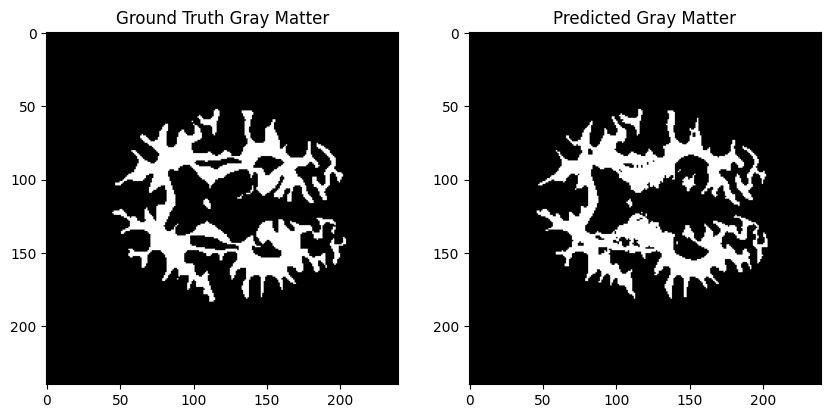

In [ ]:
# Extract gray matter masks
ground_truth_gray = (ground_truth_data == 3).astype(np.uint8)
predicted_gray = (predicted_data == 3).astype(np.uint8)

# Plot overlay of ground truth and predicted gray matter masks
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ground_truth_gray[:, :, ground_truth_gray.shape[2] // 2], cmap='gray')
plt.title('Ground Truth Gray Matter')
plt.subplot(1, 2, 2)
plt.imshow(predicted_gray[:, :, predicted_gray.shape[2] // 2], cmap='gray')
plt.title('Predicted Gray Matter')
plt.show()


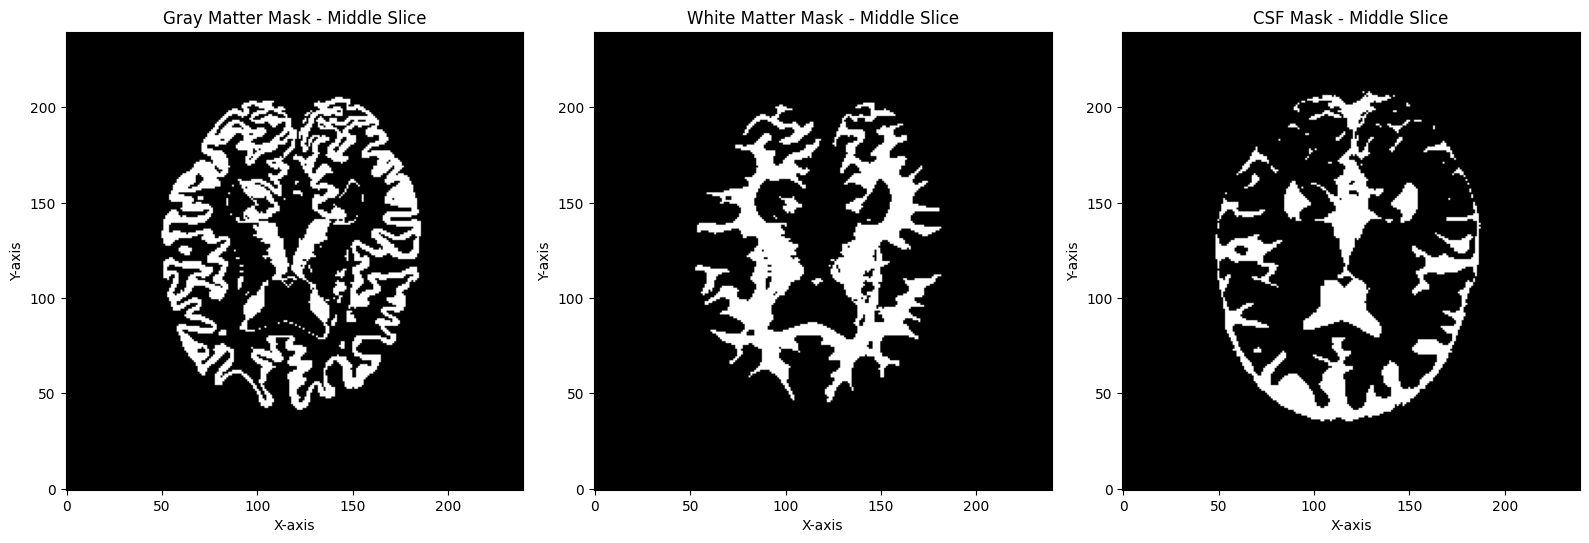

In [ ]:
# Load the probability maps for bone, tissue1, and tissue2
gray_matter_prob = nib.load('c1T1_3.nii').get_fdata()
white_matter_prob = nib.load('c2T1_3.nii').get_fdata()
csf_prob = nib.load('c3T1_3.nii').get_fdata()

# Define thresholds for bone, tissue1, and tissue2 (adjust as needed)
gray_matter_threshold = 0.5
white_matter_threshold = 0.5
csf_threshold = 0.5

# Create binary masks for each tissue based on the threshold
gray_matter_mask = (gray_matter_prob >= gray_matter_threshold).astype(np.uint8)
white_matter_mask = (white_matter_prob >= white_matter_threshold).astype(np.uint8)
csf_mask = (csf_prob >= csf_threshold).astype(np.uint8)

# Select a middle slice along the z-axis for visualization
slice_index = bone_mask.shape[2] // 2  # Middle slice for each tissue

# Extract the corresponding slices for each tissue
gray_matter_slice = gray_matter_mask[:, :, slice_index]
white_matter_slice = white_matter_mask[:, :, slice_index]
csf_slice = csf_mask[:, :, slice_index]

# Plot the binary masks for bone, tissue1, and tissue2
plt.figure(figsize=(16, 8))

# Bone slice
plt.subplot(1, 3, 1)
plt.imshow(gray_matter_slice .T, cmap='gray', origin='lower')
plt.title('Gray Matter Mask - Middle Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Tissue 1 slice
plt.subplot(1, 3, 2)
plt.imshow(white_matter_slice.T, cmap='gray', origin='lower')
plt.title('White Matter Mask - Middle Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Tissue 2 slice
plt.subplot(1, 3, 3)
plt.imshow(csf_slice.T, cmap='gray', origin='lower')
plt.title('CSF Mask - Middle Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plots
plt.tight_layout()
plt.show()


## Patient 4

In [ ]:
# Load the probability maps generated by SPM
gray_matter_prob_4 = nib.load('c1T1_4.nii').get_fdata()
white_matter_prob_4 = nib.load('c2T1_4.nii').get_fdata()
csf_prob_4 = nib.load('c3T1_4.nii').get_fdata()
bone_prob_4 = nib.load('c4T1_4.nii').get_fdata()
# soft_tissue_prob_2 = nib.load('c5T1_2.nii').get_fdata()
air_prob_4 = nib.load('c6T1_4.nii').get_fdata()

# Stack all probability maps into one array
prob_maps_4 = np.stack([csf_prob_4, gray_matter_prob_4, white_matter_prob_4], axis=-1)
background_mask_4 = np.all(prob_maps_4 < 0.1, axis=-1)  # Threshold to determine background


# Create the hard segmentation by finding the index of the maximum probability for each voxel
hard_segmentation_4 = np.argmax(prob_maps_4, axis=-1) + 1  # Adding 1 to label the classes from 1 to 6

hard_segmentation_4[background_mask_4] = 0

hard_segmentation_4 = hard_segmentation_4.astype(np.uint8)

# Save the hard segmentation as a NIfTI file
# affine contains information about the image's orientation and voxel size
# this code sets the affine transformation from one of the loaded prob maps
# ensuring that the saved segmentation has correct spatial properties
hard_seg_img = nib.Nifti1Image(hard_segmentation_4, affine=nib.load('c1T1_4.nii').affine)
nib.save(hard_seg_img, 'T1_SPM_Seg_4.nii.gz')

# Create a skull-stripped version by masking the brain tissues (classes 1, 2, and 3)
skull_stripped_mask = np.isin(hard_segmentation, [ 1, 2, 3]).astype(np.uint8)

# Save the skull-stripped mask as a NIfTI file
skull_stripped_img = nib.Nifti1Image(skull_stripped_mask, affine=nib.load('c1T1_4.nii').affine)
nib.save(skull_stripped_img, 'T1_SPM_SS_4.nii.gz')



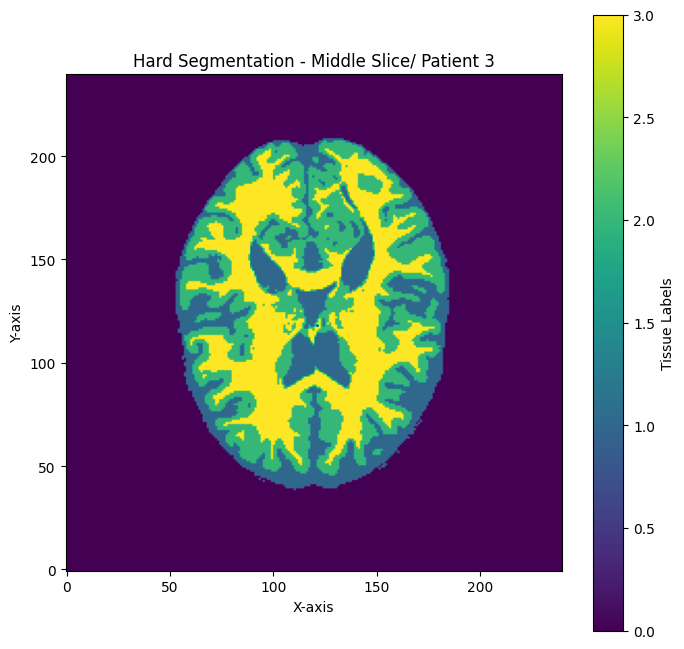

In [ ]:
# Load the hard segmentation NIfTI file
hard_seg_img = nib.load('T1_SPM_Seg_4.nii.gz')
hard_seg_data = hard_seg_img.get_fdata()

# Select a middle slice along a specific axis (e.g., the axial plane, z-axis)
slice_index = hard_seg_data.shape[2] // 2  # Middle slice
slice_data = hard_seg_data[:, :, slice_index]

# Plot the slice using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(slice_data.T, origin='lower')  # Transpose for correct orientation
plt.colorbar(label='Tissue Labels')
plt.title('Hard Segmentation - Middle Slice/ Patient 4')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


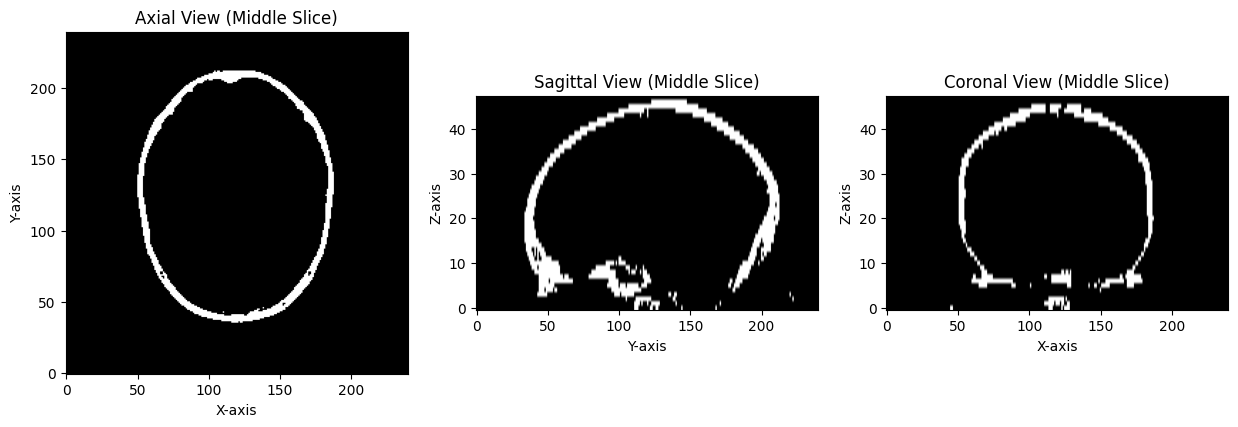

In [ ]:
# Load the bone probability map and its affine matrix
bone_prob = nib.load('c4T1_4.nii')
bone_data = bone_prob.get_fdata()
affine = bone_prob.affine

# Extract voxel dimensions from the affine matrix
voxel_sizes = np.sqrt(np.sum(affine[:3, :3] ** 2, axis=0))

# Define a threshold for the bone mask (e.g., 0.5)
bone_threshold = 0.5
bone_mask = (bone_data >= bone_threshold).astype(np.uint8)

# Determine the middle slice for each orientation
axial_slice_index = bone_mask.shape[2] // 2  # Middle slice for axial view (z-axis)
sagittal_slice_index = bone_mask.shape[0] // 2  # Middle slice for sagittal view (x-axis)
coronal_slice_index = bone_mask.shape[1] // 2  # Middle slice for coronal view (y-axis)

# Extract slices for each orientation
axial_slice = bone_mask[:, :, axial_slice_index]  # Axial slice
sagittal_slice = bone_mask[sagittal_slice_index, :, :]  # Sagittal slice
coronal_slice = bone_mask[:, coronal_slice_index, :]  # Coronal slice

# Plot each orientation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axes[0].imshow(axial_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[1] / voxel_sizes[0])
axes[0].set_title('Axial View (Middle Slice)')
axes[0].set_xlabel('X-axis')
axes[0].set_ylabel('Y-axis')

# Sagittal view
axes[1].imshow(sagittal_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[2] / voxel_sizes[1])
axes[1].set_title('Sagittal View (Middle Slice)')
axes[1].set_xlabel('Y-axis')
axes[1].set_ylabel('Z-axis')

# Coronal view
axes[2].imshow(coronal_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[2] / voxel_sizes[0])
axes[2].set_title('Coronal View (Middle Slice)')
axes[2].set_xlabel('X-axis')
axes[2].set_ylabel('Z-axis')

# Display the plots
plt.show()


In [ ]:
# Load the ground truth and predicted segmentation images
ground_truth_img = nib.load('LabelsForTesting_4.nii')
predicted_img = nib.load('T1_SPM_Seg_4.nii.gz')

# Get the data arrays
ground_truth_data = ground_truth_img.get_fdata()
predicted_data = predicted_img.get_fdata()

# Tissue labels in both images: 1 = Gray matter, 2 = White matter, 3 = CSF
tissue_labels = [ 1, 2, 3]
tissue_names = [ 'CSF', 'Gray Matter', 'White Matter']

# Calculate the Dice coefficient for each tissue type
dice_scores = {}
for tissue_label, tissue_name in zip(tissue_labels, tissue_names):
    ground_truth_mask = (ground_truth_data == tissue_label).astype(np.uint8)
    predicted_mask = (predicted_data == tissue_label).astype(np.uint8)
    dice_scores[tissue_name] = dice_coefficient(predicted_mask, ground_truth_mask)

# Print the Dice scores for each tissue type
for tissue_name, dice_score in dice_scores.items():
    print(f'Dice coefficient for {tissue_name}: {dice_score:.4f}')


Dice coefficient for CSF: 0.7837
Dice coefficient for Gray Matter: 0.7639
Dice coefficient for White Matter: 0.8156


In [ ]:
# Load the ground truth and predicted NIfTI images
ground_truth_path = 'LabelsForTesting_4.nii'
predicted_path = 'T1_SPM_Seg_4.nii.gz'

ground_truth_img = nib.load(ground_truth_path)
predicted_img = nib.load(predicted_path)

# Get the data arrays from the NIfTI images
ground_truth_data = ground_truth_img.get_fdata()
predicted_data = predicted_img.get_fdata()

# Define unique tissue labels in the ground truth (e.g., 0 for background, 1 for gray matter, etc.)
tissue_labels = np.unique(ground_truth_data)

# Initialize dictionaries to store mean and std for each tissue
mean_values = {}
std_values = {}

# Loop over each tissue label
for label in tissue_labels:
    # Extract regions of the current tissue in the predicted image
    tissue_region_pred = predicted_data[ground_truth_data == label]

    # Check if there are any voxels for this label
    if tissue_region_pred.size > 0:
        # Calculate mean and standard deviation
        mean_values[label] = np.mean(tissue_region_pred)
        std_values[label] = np.std(tissue_region_pred)
    else:
        mean_values[label] = None
        std_values[label] = None

# Output the results
for label in tissue_labels:
    print(f'Tissue Label {label}: Mean = {mean_values[label]}, Standard Deviation = {std_values[label]}')


Tissue Label 0.0: Mean = 0.055531825467985116, Standard Deviation = 0.330812670470361
Tissue Label 1.0: Mean = 1.1260096604037968, Standard Deviation = 0.38039963773120505
Tissue Label 2.0: Mean = 2.062589135602064, Standard Deviation = 0.4150782052466169
Tissue Label 3.0: Mean = 2.908010203110426, Standard Deviation = 0.29648924858598286


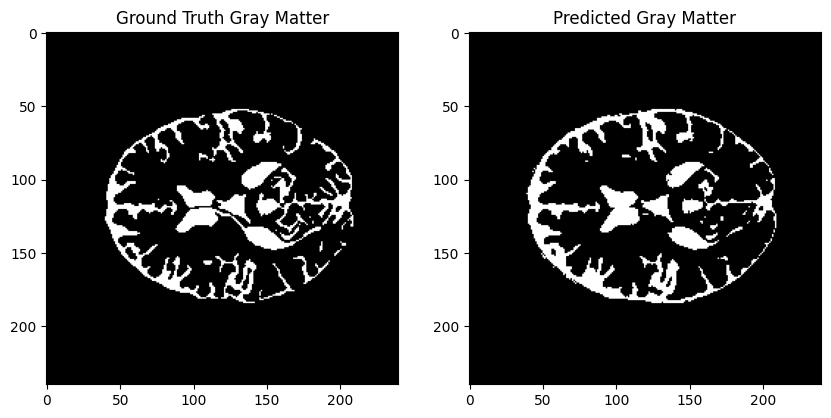

In [ ]:

# Extract gray matter masks
ground_truth_gray = (ground_truth_data == 1).astype(np.uint8)
predicted_gray = (predicted_data == 1).astype(np.uint8)

# Plot overlay of ground truth and predicted gray matter masks
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ground_truth_gray[:, :, ground_truth_gray.shape[2] // 2], cmap='gray')
plt.title('Ground Truth Gray Matter')
plt.subplot(1, 2, 2)
plt.imshow(predicted_gray[:, :, predicted_gray.shape[2] // 2], cmap='gray')
plt.title('Predicted Gray Matter')
plt.show()


## Patient 5

In [ ]:

# Load the probability maps generated by SPM
gray_matter_prob_5 = nib.load('c1T1_5.nii').get_fdata()
white_matter_prob_5 = nib.load('c2T1_5.nii').get_fdata()
csf_prob_5 = nib.load('c3T1_5.nii').get_fdata()
bone_prob_5 = nib.load('c4T1_5.nii').get_fdata()
# soft_tissue_prob_2 = nib.load('c5T1_2.nii').get_fdata()
air_prob_5 = nib.load('c6T1_5.nii').get_fdata()

# Stack all probability maps into one array
prob_maps_5 = np.stack([csf_prob_5, gray_matter_prob_5, white_matter_prob_5], axis=-1)

background_mask_5 = np.all(prob_maps_5 < 0.1, axis=-1)  # Threshold to determine background

# Create the hard segmentation by finding the index of the maximum probability for each voxel
hard_segmentation_5 = np.argmax(prob_maps_5, axis=-1) + 1  # Adding 1 to label the classes from 1 to 6


hard_segmentation_5[background_mask_5] = 0
hard_segmentation_5 = hard_segmentation_5.astype(np.uint8)


# Save the hard segmentation as a NIfTI file
# affine contains information about the image's orientation and voxel size
# this code sets the affine transformation from one of the loaded prob maps
# ensuring that the saved segmentation has correct spatial properties
hard_seg_img = nib.Nifti1Image(hard_segmentation_5, affine=nib.load('c1T1_5.nii').affine)
nib.save(hard_seg_img, 'T1_SPM_Seg_5.nii.gz')

# Create a skull-stripped version by masking the brain tissues (classes 1, 2, and 3)
skull_stripped_mask = np.isin(hard_segmentation, [1, 2, 3]).astype(np.uint8)

# Save the skull-stripped mask as a NIfTI file
skull_stripped_img = nib.Nifti1Image(skull_stripped_mask, affine=nib.load('c1T1_5.nii').affine)
nib.save(skull_stripped_img, 'T1_SPM_SS_5.nii.gz')


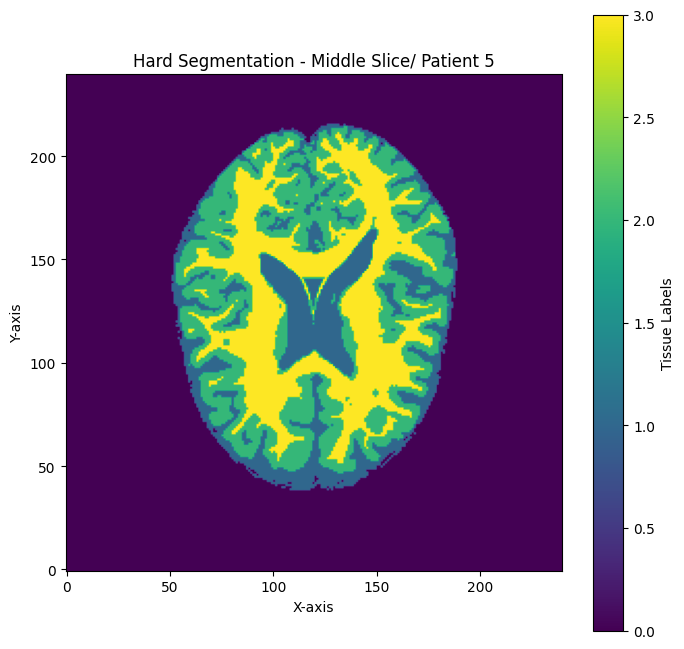

In [ ]:
# Load the hard segmentation NIfTI file
hard_seg_img = nib.load('T1_SPM_Seg_5.nii.gz')
hard_seg_data = hard_seg_img.get_fdata()

# Select a middle slice along a specific axis (e.g., the axial plane, z-axis)
slice_index = hard_seg_data.shape[2] // 2  # Middle slice
slice_data = hard_seg_data[:, :, slice_index]

# Plot the slice using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(slice_data.T, origin='lower')  # Transpose for correct orientation
plt.colorbar(label='Tissue Labels')
plt.title('Hard Segmentation - Middle Slice/ Patient 5')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


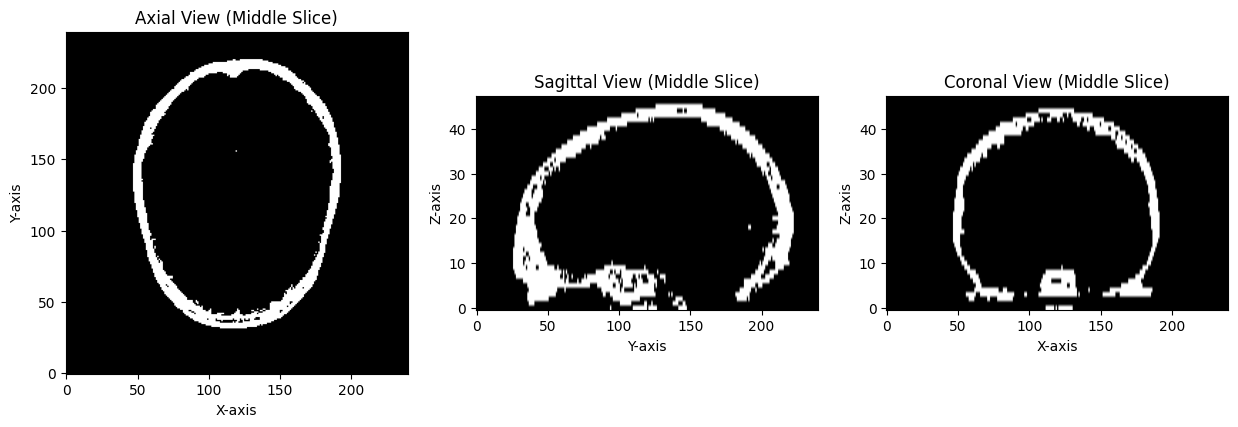

In [ ]:
# Load the bone probability map and its affine matrix
bone_prob = nib.load('c4T1_5.nii')
bone_data = bone_prob.get_fdata()
affine = bone_prob.affine

# Extract voxel dimensions from the affine matrix
voxel_sizes = np.sqrt(np.sum(affine[:3, :3] ** 2, axis=0))

# Define a threshold for the bone mask (e.g., 0.5)
bone_threshold = 0.5
bone_mask = (bone_data >= bone_threshold).astype(np.uint8)

# Determine the middle slice for each orientation
axial_slice_index = bone_mask.shape[2] // 2  # Middle slice for axial view (z-axis)
sagittal_slice_index = bone_mask.shape[0] // 2  # Middle slice for sagittal view (x-axis)
coronal_slice_index = bone_mask.shape[1] // 2  # Middle slice for coronal view (y-axis)

# Extract slices for each orientation
axial_slice = bone_mask[:, :, axial_slice_index]  # Axial slice
sagittal_slice = bone_mask[sagittal_slice_index, :, :]  # Sagittal slice
coronal_slice = bone_mask[:, coronal_slice_index, :]  # Coronal slice

# Plot each orientation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axes[0].imshow(axial_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[1] / voxel_sizes[0])
axes[0].set_title('Axial View (Middle Slice)')
axes[0].set_xlabel('X-axis')
axes[0].set_ylabel('Y-axis')

# Sagittal view
axes[1].imshow(sagittal_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[2] / voxel_sizes[1])
axes[1].set_title('Sagittal View (Middle Slice)')
axes[1].set_xlabel('Y-axis')
axes[1].set_ylabel('Z-axis')

# Coronal view
axes[2].imshow(coronal_slice.T, cmap='gray', origin='lower', aspect=voxel_sizes[2] / voxel_sizes[0])
axes[2].set_title('Coronal View (Middle Slice)')
axes[2].set_xlabel('X-axis')
axes[2].set_ylabel('Z-axis')

# Display the plots
plt.show()


In [ ]:
# Function to calculate Dice coefficient
def dice_coefficient(pred, truth):
    intersection = np.sum((pred > 0) & (truth > 0))
    volume_sum = np.sum(pred > 0) + np.sum(truth > 0)
    if volume_sum == 0:
        return 1.0  # Return perfect match if both volumes are empty
    return 2 * intersection / volume_sum

# Load the ground truth and predicted segmentation images
ground_truth_img = nib.load('LabelsForTesting_5.nii')
predicted_img = nib.load('T1_SPM_Seg_5.nii.gz')

# Get the data arrays
ground_truth_data = ground_truth_img.get_fdata()
predicted_data = predicted_img.get_fdata()

# Tissue labels in both images: 1 = Gray matter, 2 = White matter, 3 = CSF
tissue_labels = [ 1, 2, 3]
tissue_names = ['CSF', 'Gray Matter', 'White Matter']

# Calculate the Dice coefficient for each tissue type
dice_scores = {}
for tissue_label, tissue_name in zip(tissue_labels, tissue_names):
    ground_truth_mask = (ground_truth_data == tissue_label).astype(np.uint8)
    predicted_mask = (predicted_data == tissue_label).astype(np.uint8)
    dice_scores[tissue_name] = dice_coefficient(predicted_mask, ground_truth_mask)

# Print the Dice scores for each tissue type
for tissue_name, dice_score in dice_scores.items():
    print(f'Dice coefficient for {tissue_name}: {dice_score:.4f}')


Dice coefficient for CSF: 0.7603
Dice coefficient for Gray Matter: 0.7876
Dice coefficient for White Matter: 0.8434


In [ ]:
# Load the ground truth and predicted NIfTI images
ground_truth_path = 'LabelsForTesting_5.nii'
predicted_path = 'T1_SPM_Seg_5.nii.gz'

ground_truth_img = nib.load(ground_truth_path)
predicted_img = nib.load(predicted_path)

# Get the data arrays from the NIfTI images
ground_truth_data = ground_truth_img.get_fdata()
predicted_data = predicted_img.get_fdata()

# Define unique tissue labels in the ground truth (e.g., 0 for background, 1 for gray matter, etc.)
tissue_labels = np.unique(ground_truth_data)

# Initialize dictionaries to store mean and std for each tissue
mean_values = {}
std_values = {}

# Loop over each tissue label
for label in tissue_labels:
    # Extract regions of the current tissue in the predicted image
    tissue_region_pred = predicted_data[ground_truth_data == label]

    # Check if there are any voxels for this label
    if tissue_region_pred.size > 0:
        # Calculate mean and standard deviation
        mean_values[label] = np.mean(tissue_region_pred)
        std_values[label] = np.std(tissue_region_pred)
    else:
        mean_values[label] = None
        std_values[label] = None

# Output the results
for label in tissue_labels:
    print(f'Tissue Label {label}: Mean = {mean_values[label]}, Standard Deviation = {std_values[label]}')


Tissue Label 0.0: Mean = 0.07170142043981206, Standard Deviation = 0.38888605462318715
Tissue Label 1.0: Mean = 1.0113940446919574, Standard Deviation = 0.44732512005406777
Tissue Label 2.0: Mean = 1.977535472812113, Standard Deviation = 0.37316680357807114
Tissue Label 3.0: Mean = 2.89172925458174, Standard Deviation = 0.32288819716119216


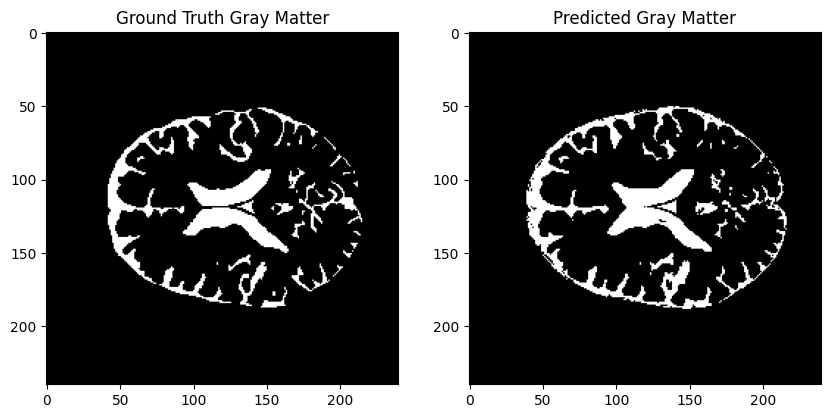

In [ ]:

# Extract gray matter masks
ground_truth_gray = (ground_truth_data == 1).astype(np.uint8)
predicted_gray = (predicted_data == 1).astype(np.uint8)

# Plot overlay of ground truth and predicted gray matter masks
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ground_truth_gray[:, :, ground_truth_gray.shape[2] // 2], cmap='gray')
plt.title('Ground Truth Gray Matter')
plt.subplot(1, 2, 2)
plt.imshow(predicted_gray[:, :, predicted_gray.shape[2] // 2], cmap='gray')
plt.title('Predicted Gray Matter')
plt.show()
